# 0. Importing Dependencies

In [282]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random

from pprint import pprint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

random.seed(42)

In [283]:
parent_dir = os.path.abspath("..")
sys.path.append(parent_dir + "/api_scraper")
import database
from database import StockData

# 1. Loading and Preparing Dataset

In [284]:
def stockdata_to_tensor(x: StockData) -> torch.tensor:
    return torch.tensor(list(zip(*x)))

def stockdata_to_list(x: StockData):
    return list(zip(*x))

def partition_symbols(all_symbols: list[str]) -> tuple[list[str], list[str]]:
    """
    Randomly selects 90% of the symbols to be used for training
    Returns the sampled symbols (used for training) AND not-sampled symbols (used for evaluation)
    """
    sample_size = int(len(all_symbols) * 0.90)
    
    sample = random.sample(all_symbols, sample_size)
    non_sample = [x for x in all_symbols if x not in sample]
    
    return sample, non_sample

def get_data(symbols: list[str]) -> torch.tensor:
    """
    Given a list of symbols, retrieves the stock data from the database
    and returns the data as a tensor.
    
    shape: [num_symbols, 490, num_features (currently 5)]
        TODO: more features such as MACD, EMA
    """
    data = []
    for symbol in symbols:
        try:
            stock_data = database.get_stock_data(symbol)
            stock_data = stockdata_to_list(stock_data)
            data.append(stock_data)
        except:
            print(symbol)
            continue
    data = torch.tensor(data)
    
    return data

In [285]:
all_symbols = database.get_all_symbols()
sampled_symbols, not_sampled_symbols = partition_symbols(all_symbols)

# data = [stockdata_to_list(database.get_stock_data(x)) for x in all_symbols]
data = get_data(sampled_symbols)
eval_data = get_data(not_sampled_symbols)

"""
Within each stock's history, scale their prices
to a relative (0,1) range
"""

scaler = MinMaxScaler(feature_range=(0,1))

def scale_data(data: torch.tensor) -> torch.tensor:
    scaled_data = torch.empty_like(data)
    for i in range(len(data)):
        stock_data = data[i]
        scaled_stock = torch.tensor(scaler.fit_transform(stock_data), dtype=torch.float32)
        scaled_data[i] = scaled_stock
        
    return scaled_data

scaled_data = scale_data(data)
    
scaled_data.shape

torch.Size([133, 490, 5])

In [286]:

# feature indexes (dim 2)
# 0: open
# 1: close
# 2: low
# 3: high
# 4: volume

class StockPriceDataset(Dataset):
    def __init__(self, data, time_steps):
        self.sequences = []
        self.labels = []
        for stock_data in data:
            seq, lbl = self._create_sequences(stock_data, time_steps)
            self.sequences.append(seq)
            self.labels.append(lbl)
            
        self.sequences = np.concatenate(self.sequences, axis=0)
        self.labels = np.concatenate(self.labels, axis=0)
        
        
    def __len__(self):
        return len(self.sequences)
    
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), \
            torch.tensor(self.labels[idx], dtype=torch.float32)
            
            
    def _create_sequences(self, stock_data, time_steps):
        """
        Creates sequences of length {time_steps},
        compiles them into an array that contains all possible
        contiguous sequences.
        """
        sequences = []
        labels = []
        for i in range(len(stock_data) - time_steps):
            sequences.append(stock_data[i: i+time_steps])
            labels.append(stock_data[i+time_steps, 1])
        sequences = np.array([x.numpy() for x in sequences])    # Convert inner tensors to numpy array first
        labels = np.array(labels)
        return sequences, labels
    

class CustomStockPriceDataset(StockPriceDataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    

In [287]:
dataset = StockPriceDataset(scaled_data, 14)
print(f"sequences shape: {dataset.sequences.shape}")
print(f"labels shape: {dataset.labels.shape}")

sequences shape: (63308, 14, 5)
labels shape: (63308,)


In [288]:
def create_data_split(dataset):
    """
    Create a 70-20-10 train-val-test data split
    """

    train_sequences, val_sequences, train_labels, val_labels = train_test_split(
        dataset.sequences, dataset.labels, test_size=0.3, random_state=42
    )

    val_sequences, test_sequences, val_labels, test_labels = train_test_split(
        val_sequences, val_labels, test_size=0.33, random_state=42
    )
    
    return train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels

train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels = create_data_split(dataset)

print(f"Training sequences shape: {train_sequences.shape}")
print(f"Validation sequences shape: {val_sequences.shape}")
print(f"Test sequences shape: {test_sequences.shape}")
print()
print(f"Training labels shape: {train_labels.shape}")
print(f"Validation labels shape: {val_labels.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training sequences shape: (44315, 14, 5)
Validation sequences shape: (12725, 14, 5)
Test sequences shape: (6268, 14, 5)

Training labels shape: (44315,)
Validation labels shape: (12725,)
Test labels shape: (6268,)


In [289]:
def create_dataloader(sequences, labels, batch_size):
    custom_dataset = CustomStockPriceDataset(sequences, labels)
    
    dataloader = DataLoader(custom_dataset, batch_size, shuffle=True)
    
    return dataloader

batch_size = 32

train_dataloader = create_dataloader(train_sequences, train_labels, batch_size)
val_dataloader = create_dataloader(val_sequences, val_labels, batch_size)
test_dataloader = create_dataloader(test_sequences, test_labels, batch_size)

# 1.1 Condensed Data Processing (Only Run This Function Below)

In [276]:
def get_processed_data(symbols: list[str], time_window, batch_size) -> tuple[DataLoader, DataLoader, DataLoader]: 
    """
    Condensed version of everything above into a single function.
    Returns DataLoaders for training, validation, and testing
    """
    # Get the raw data as a tesnor
    data = get_data(symbols)
    
    # Scale the data to a (0, 1) within each column (field)
    scaled_data = scale_data(data)
    
    # Convert the scaled data into a dataset of sequences and their labels whose length is specified by {time_window}
    dataset = StockPriceDataset(scaled_data, time_window)
    
    # Creates a split of these sequences and labels into a train-val-test split
    train_sequences, train_labels, val_sequences, val_labels, test_sequences, test_labels = create_data_split(dataset)
    
    # Turns these sequences and labels into dataloaders
    train_dataloader = create_dataloader(train_sequences, train_labels, batch_size)
    val_dataloader = create_dataloader(val_sequences, val_labels, batch_size)
    test_dataloader = create_dataloader(test_sequences, test_labels, batch_size)
    
    return train_dataloader, val_dataloader, test_dataloader
    

In [272]:
train_dataloader, val_dataloader, test_dataloader = get_processed_data(sampled_symbols, 14, 32)

# 2. Defining LSTM Model

In [265]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, 
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out_last = lstm_out[:,-1,:]
        out = self.fc(out_last)
        
        return out

In [266]:
input_size = 5
hidden_size = 50
num_layers = 2
learning_rate = 0.001
num_epochs = 10

model = LSTMModel(input_size, hidden_size, num_layers)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

In [292]:
def train_model(model, num_epochs, 
                train_loader, val_loader,
                optimizer, criterion):
    training_losses = []
    validation_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for sequences, targets in train_loader:
            optimizer.zero_grad()
            predictions = model(sequences)
            loss = criterion(predictions.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        avg_train_loss = running_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        
        model.eval()
        with torch.no_grad():
            running_loss_val = 0.0
            for sequences, targets in val_loader:
                predictions = model(sequences)
                loss = criterion(predictions.squeeze(), targets)
                running_loss_val += loss.item()
            avg_val_loss = running_loss_val / len(val_loader)
            validation_losses.append(avg_val_loss)
            
            
        print(f"Epoch {epoch+1:>2} / {num_epochs} || Train Loss: {avg_train_loss:<30} || Validation Loss: {avg_val_loss:<30}")
    
    return training_losses, validation_losses
                

In [213]:
training_losses, validation_losses = train_model(model, 20, train_dataloader, val_dataloader, optimizer, criterion)

Epoch  1 / 20 || Train Loss: 0.003917501203733452 || Validation Loss: 0.0014377912257396706
Epoch  2 / 20 || Train Loss: 0.0013144241810468655 || Validation Loss: 0.001308256277247641
Epoch  3 / 20 || Train Loss: 0.0012567796158757304 || Validation Loss: 0.001249844545759401
Epoch  4 / 20 || Train Loss: 0.0012123214631906242 || Validation Loss: 0.0011895426375198824
Epoch  5 / 20 || Train Loss: 0.0011948633032080984 || Validation Loss: 0.0012042634894787077
Epoch  6 / 20 || Train Loss: 0.0011848466320380246 || Validation Loss: 0.001403447306330606
Epoch  7 / 20 || Train Loss: 0.0011791166078235402 || Validation Loss: 0.0012734240420711408
Epoch  8 / 20 || Train Loss: 0.001158106931029661 || Validation Loss: 0.0011906684554724874
Epoch  9 / 20 || Train Loss: 0.0011710618653491018 || Validation Loss: 0.0011845731212852299
Epoch 10 / 20 || Train Loss: 0.0011612605190052506 || Validation Loss: 0.0011716455867749184
Epoch 11 / 20 || Train Loss: 0.0011530019570896838 || Validation Loss: 0.00

In [294]:
def plot_losses(training_losses, validation_losses):
    plt.clf()
    training_losses = torch.FloatTensor(training_losses)
    validation_losses = torch.FloatTensor(validation_losses)
    
    plt.plot(training_losses, label="Training")
    plt.plot(validation_losses, label="Validation")
    plt.legend(loc="upper right")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

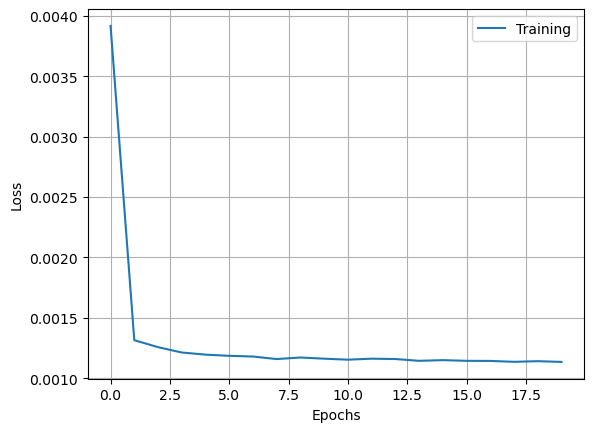

In [230]:
plot_losses(training_losses)

In [232]:
with torch.no_grad():
    running_test_loss = 0.0
    for sequences, targets in test_dataloader:
        predictions = model(sequences)
        loss = criterion(predictions.squeeze(), targets)
        running_test_loss += loss.item()
        
    avg_test_loss = running_test_loss / len(test_dataloader)
    
    print(avg_test_loss)

0.0012065715679770563


In [233]:
model_path = os.path.abspath(".") + "/model1.pt"
torch.save(model, model_path)

# 3.5. Model Loading

In [234]:
model = torch.load("model_14day.pt")

# 4. Model Evaluation

In [299]:
def predict_stock(model: nn.Module, stock_name: str) -> None:
    stock_data = database.get_stock_data(stock_name)
    scaler = MinMaxScaler(feature_range=(0,1))
    stock_closing_prices = torch.FloatTensor(stock_data.close_price)
    
    stock_data = stockdata_to_tensor(stock_data)
    
    scaled_stock_data = torch.tensor(scaler.fit_transform(stock_data), dtype=torch.float32)
    predictions = get_predictions(model, scaled_stock_data, stock_closing_prices)
    
    plt.clf()
    plt.plot(predictions, label="Predicted")
    plt.plot(stock_closing_prices[14:], label="Actual")
    plt.legend(loc="upper left")
    plt.title(f"Stock predictions for {stock_name}")
    plt.ylabel(f"Price")
    plt.xlabel(f"Day")
    plt.grid(True)
    plt.show()
    
    
def get_predictions(model: nn.Module, scaled_data: np.array, closing_prices: tuple[float]) -> torch.FloatTensor:
    predictions = []
    for i in range(scaled_data.shape[0]-14):
        sequence = scaled_data[i:i+14].unsqueeze(0)
        prediction = model(sequence).item()
        
        # Get price change percentage from prediction and latest closing price
        # Then make that percentage change from the latest closing price to get the predicted next-day price
        latest_closing_price = sequence[0][-1][1].item()
        price_change_percentage = (prediction - latest_closing_price) / 1
        actual_previous_price = closing_prices[i+14]
        
        unscaled_predicted_price = actual_previous_price * (1 + price_change_percentage)
        predictions.append(unscaled_predicted_price)
    
    return torch.FloatTensor(predictions)


In [251]:
not_sampled_symbols

['MSFT',
 'JPM',
 'MSI',
 'CMG',
 'LOW',
 'LMT',
 'V',
 'PDD',
 'CAT',
 'COP',
 'SYK',
 'SNY',
 'ELV',
 'AMT',
 'WDAY']

# TODO: Try scaling within each interval to introduce equivariance in relative prices over the 2-yr interval

In [297]:
def evaluate_non_sampled_symbols(model: nn.Module, not_sampled_symbols: list[str]) -> None:
    scaler = MinMaxScaler(feature_range=(0,1))

    fig, axis = plt.subplots(nrows=len(not_sampled_symbols), ncols=1, figsize=(8, 6*len(not_sampled_symbols)))

    for i, symbol in enumerate(not_sampled_symbols):
        stock_data = database.get_stock_data(symbol)
        stock_closing_prices = torch.FloatTensor(stock_data.close_price)
        
        stock_data = stockdata_to_tensor(stock_data)
        scaled_stock_data = torch.tensor(scaler.fit_transform(stock_data), dtype=torch.float32)
        
        predictions = get_predictions(model, scaled_stock_data, stock_closing_prices)
        
        axis[i].plot(predictions, label="Predicted")
        axis[i].plot(stock_closing_prices[14:], label="Actual")
        axis[i].legend(loc="upper left")
        axis[i].set_title(f"Actual vs. Predicted Prices for ${symbol}")
        axis[i].set_xlabel("Time")
        axis[i].set_ylabel("Stock Price")
        axis[i].grid(True)

    plt.show()
    
evaluate_non_sampled_symbols(model, not_sampled_symbols)

# 5. Additional Models

### 5.1 Larger Time Window (30 days)

In [290]:
LR = 0.001
BATCH_SIZE = 32

model_30day = LSTMModel(input_size, hidden_size, num_layers)
optimizer = optim.AdamW(model_30day.parameters(), lr=LR, amsgrad=True)
criterion = nn.SmoothL1Loss()

In [291]:
all_symbols = database.get_all_symbols()
random.seed(50)
sampled_symbols, not_sampled_symbols = partition_symbols(all_symbols)
train_dataloader, val_dataloader, test_dataloader = get_processed_data(sampled_symbols, 30, BATCH_SIZE)

In [293]:
training_losses, validation_losses = train_model(model_30day, num_epochs=12, 
            train_loader=train_dataloader, val_loader=val_dataloader, 
            optimizer=optimizer, criterion=criterion)

Epoch  1 / 12 || Train Loss: 0.0039933371666089935          || Validation Loss: 0.0014684612311682869         
Epoch  2 / 12 || Train Loss: 0.0012948141478551893          || Validation Loss: 0.0012416174009369759         
Epoch  3 / 12 || Train Loss: 0.00120919506294031            || Validation Loss: 0.0013884482927946978         
Epoch  4 / 12 || Train Loss: 0.0011841563835664102          || Validation Loss: 0.0012492799799580902         
Epoch  5 / 12 || Train Loss: 0.0011579639601254803          || Validation Loss: 0.001285509099237403          
Epoch  6 / 12 || Train Loss: 0.001154453324139587           || Validation Loss: 0.0011760252258776651         
Epoch  7 / 12 || Train Loss: 0.001150082890557256           || Validation Loss: 0.0011994068739125383         
Epoch  8 / 12 || Train Loss: 0.0011451230708050977          || Validation Loss: 0.0011642448927650785         
Epoch  9 / 12 || Train Loss: 0.0011264338091821246          || Validation Loss: 0.0011626412574951717         
E

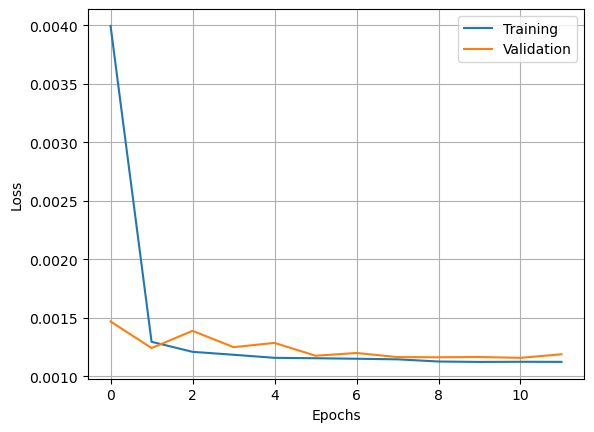

In [295]:
plot_losses(training_losses, validation_losses)

In [296]:
not_sampled_symbols

['C',
 'TSLA',
 'TMUS',
 'WMT',
 'T',
 'XOM',
 'UPS',
 'EXPE',
 'SCHW',
 'UNH',
 'ETN',
 'COP',
 'RACE',
 'COF',
 'ROP']

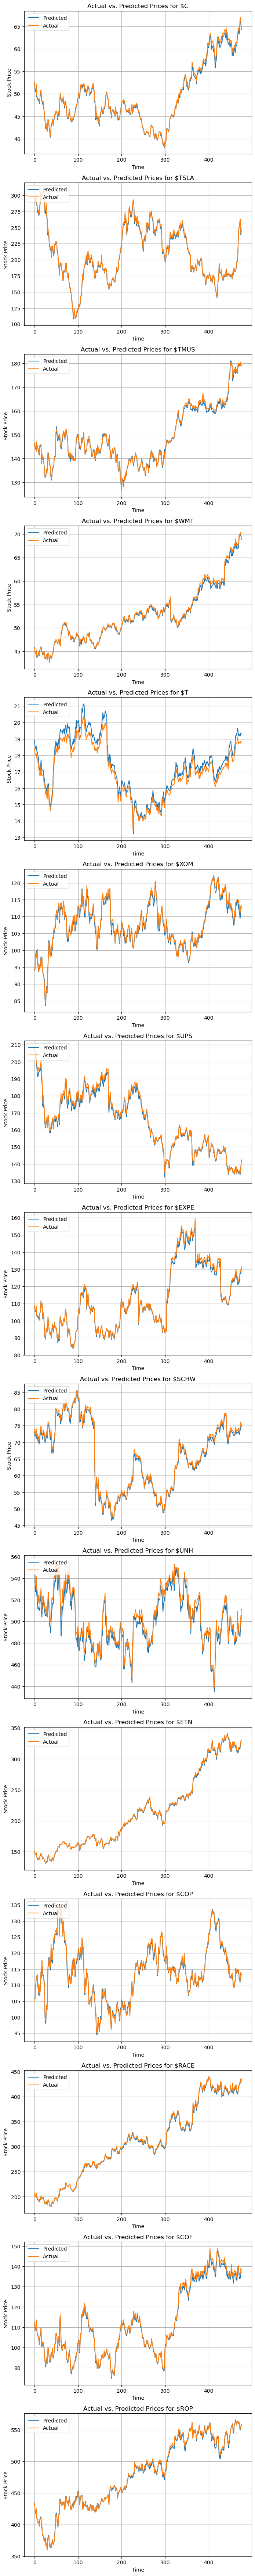

In [301]:
evaluate_non_sampled_symbols(model_30day, not_sampled_symbols)